In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

## Generating the Data

In [44]:
def randomData(samples_per_class = 1000, classes = 3, noise_features = 0):
    class1 = np.random.multivariate_normal(mean = [1.5,1.5], cov = np.identity(2), size = samples_per_class)
    class2 = np.random.multivariate_normal(mean = [-1.5,1.5], cov = np.identity(2), size = samples_per_class)
    class3 = np.random.multivariate_normal(mean = [0,-1.5*np.sqrt(2)], cov = np.identity(2), size = samples_per_class) 
    
    if noise_features > 0:
        noiseX = np.random.rand(3*samples_per_class, noise_features)
        X = np.concatenate([class1, class2, class3], axis = 0)
        X = np.concatenate([X, noiseX], axis = 1)
    else:
        X = np.concatenate([class1, class2, class3], axis = 0)
    
    y = [0] * samples_per_class + [1] * samples_per_class + [2] * samples_per_class

    return X, y

In [29]:
colors = {0: "blue", 1: "red", 2: "green" }

In [45]:
class2 = np.random.multivariate_normal(mean = [-1,1], cov = np.identity(2), size = 100)

In [46]:
x, y = randomData(samples_per_class= 333)

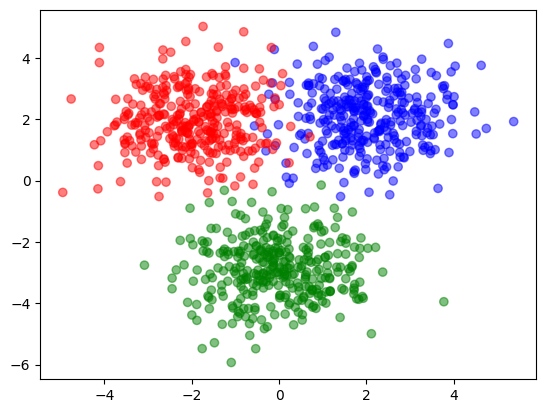

In [47]:
plt.scatter(x=x[:,0], y=x[:,1], c=[colors[label] for label in y], alpha=0.5)